In [1]:
!pip install tensorflow==1.5
!pip install keras

    100% |████████████████████████████████| 44.4MB 19kB/s eta 0:00:011  10% |███▍                            | 4.6MB 1.4MB/s eta 0:00:29    10% |███▌                            | 4.8MB 1.3MB/s eta 0:00:31    12% |████                            | 5.6MB 2.8MB/s eta 0:00:15    43% |█████████████▉                  | 19.3MB 1.3MB/s eta 0:00:19    50% |████████████████                | 22.2MB 1.3MB/s eta 0:00:18    51% |████████████████▌               | 22.9MB 365kB/s eta 0:00:59    52% |████████████████▉               | 23.4MB 9.0MB/s eta 0:00:03    54% |█████████████████▍              | 24.2MB 21.7MB/s eta 0:00:01    70% |██████████████████████▋         | 31.4MB 2.9MB/s eta 0:00:05    90% |████████████████████████████▉   | 40.1MB 1.2MB/s eta 0:00:04
    100% |████████████████████████████████| 3.0MB 262kB/s eta 0:00:01
    100% |████████████████████████████████| 1.1MB 672kB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 1.8MB/s ta 0:00:01
    100% |█████████████████████████

In [2]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

Using TensorFlow backend.


### data setup

#### load input and output sentance vectors

In [3]:
word_em_in = './data/twitspace.tsv'

# load word embeddings
word_embeddings = {}
with open(word_em_in, 'r', encoding='utf-8') as w_in:
    for line in w_in:
        line = line.replace('\n','')
        line = line.split('\t')
        word_embeddings[line[0]] = np.array(line[1:]).astype(float)

print(word_embeddings['hello'].shape)

(100,)


In [4]:
conversation_in = './data/twitter.data'

conversations_embedding_list_x = []
conversations_embedding_list_y = []
max_seq_len = 0
with open(conversation_in, 'r', encoding='utf-8') as c_in:
    for line in c_in:
        line = line.replace('\n','')
        line = line.split('\t')
        utterance_embedding_list = []
        convs_len = len(line)
        if convs_len > 1:
            if convs_len > max_seq_len:
                max_seq_len = convs_len
            for utterance in line:
                sentance_embedding = np.zeros(100,)
                wcount = 0.0
                for word in utterance.split(' '):
                    sentance_embedding = np.add(sentance_embedding, word_embeddings[word])
                    wcount = wcount + 1.0
                # sentance_embedding = np.divide(sentance_embedding, wcount)
                utterance_embedding_list.append(sentance_embedding)
            conversations_embedding_list_x.append(np.array(utterance_embedding_list[0:convs_len-1]))
            conversations_embedding_list_y.append(np.array(utterance_embedding_list[1:]))

print(len(conversations_embedding_list_x), convs_len)

1899 20


In [5]:
conversations_embedding_list_x[4].shape

(3, 100)

In [6]:
# print(conversations_embedding_list_x[0])
# print(conversations_embedding_list_y[0])

In [7]:
# padding and splitting of data
count_t = 0
for conv in conversations_embedding_list_x:
    conv_len = len(conv)
    remain_len = max_seq_len - conv_len
    attach = np.zeros((remain_len, 100), dtype=float)
    conv_t = np.concatenate((conv, attach), axis=0)
    conversations_embedding_list_x[count_t] = conv_t
    count_t = count_t + 1

conversations_embedding_list_x = np.array(conversations_embedding_list_x)

count_t = 0
for conv in conversations_embedding_list_y:
    conv_len = len(conv)
    remain_len = max_seq_len - conv_len
    attach = np.zeros((remain_len, 100), dtype=float)
    conv_t = np.concatenate((conv, attach), axis=0)
    conversations_embedding_list_y[count_t] = conv_t
    count_t = count_t + 1
    
conversations_embedding_list_y = np.array(conversations_embedding_list_y)
    
# shuffle data
c = np.c_[conversations_embedding_list_x.reshape(len(conversations_embedding_list_x), -1), conversations_embedding_list_y.reshape(len(conversations_embedding_list_y), -1)]
conversations_x = c[:, :conversations_embedding_list_x.size//len(conversations_embedding_list_x)].reshape(conversations_embedding_list_x.shape)
conversations_y = c[:, conversations_embedding_list_x.size//len(conversations_embedding_list_x):].reshape(conversations_embedding_list_y.shape)
np.random.shuffle(c)
    
print(conversations_x[120].shape)
print(conversations_y[120].shape)

(21, 100)
(21, 100)


In [8]:
print(conversations_x[184])
print(conversations_y[184])

[[-0.27565324  0.18765026 -0.25614886 ... -0.21140989  0.17627499
  -0.08317564]
 [-0.32836602  0.02042369 -0.18080315 ... -0.11436018  0.00299232
   0.024083  ]
 [-0.58724438  0.18172591 -0.10085606 ... -0.27159132  0.14645953
  -0.11492114]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[[-0.32836602  0.02042369 -0.18080315 ... -0.11436018  0.00299232
   0.024083  ]
 [-0.58724438  0.18172591 -0.10085606 ... -0.27159132  0.14645953
  -0.11492114]
 [-0.24038929  0.13084488 -0.15768116 ... -0.09246979  0.1089746
  -0.03903927]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


#### create a generator

In [9]:
from random import randint
import math

data_x_limit = len(conversations_x)
s_batch = 50
n_batch = math.floor((data_x_limit / s_batch))
print(data_x_limit,n_batch)

def generator():
    step = 0
    while True:
        step = step + 1
        if step > n_batch+1:
            step = 1
        yield conversations_x[s_batch*(step-1):s_batch*(step)], conversations_y[s_batch*(step-1):s_batch*(step)]

1899 37


### build LSTM model

In [10]:
model = Sequential()
model.add(LSTM((100), batch_input_shape=(None, None, (100)), return_sequences=True))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 100)         80400     
Total params: 80,400
Trainable params: 80,400
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit_generator(generator(), samples_per_epoch=n_batch, nb_epoch=2000)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=37, epochs=2000)`
  """Entry point for launching an IPython kernel.


Epoch 1/2000
37/37 [==============================] - 1s 38ms/step - loss: 0.0014 - acc: 0.0045
Epoch 2/2000
37/37 [==============================] - 1s 32ms/step - loss: 0.0013 - acc: 0.0137
Epoch 3/2000
37/37 [==============================] - 1s 32ms/step - loss: 0.0012 - acc: 0.0218
Epoch 4/2000
37/37 [==============================] - 1s 32ms/step - loss: 0.0011 - acc: 0.0265
Epoch 5/2000
37/37 [==============================] - 1s 32ms/step - loss: 0.0011 - acc: 0.0300
Epoch 6/2000
37/37 [==============================] - 1s 32ms/step - loss: 0.0011 - acc: 0.0320
Epoch 7/2000
37/37 [==============================] - 1s 32ms/step - loss: 0.0011 - acc: 0.0325
Epoch 8/2000
37/37 [==============================] - 1s 32ms/step - loss: 0.0011 - acc: 0.0334
Epoch 9/2000
37/37 [==============================] - 1s 32ms/step - loss: 0.0011 - acc: 0.0343
Epoch 10/2000
37/37 [==============================] - 1s 32ms/step - loss: 0.0011 - acc: 0.0341
Epoch 11/2000
37/37 [==================

37/37 [==============================] - 2s 45ms/step - loss: 0.0010 - acc: 0.0410
Epoch 86/2000
37/37 [==============================] - 1s 33ms/step - loss: 9.9787e-04 - acc: 0.0403
Epoch 87/2000
37/37 [==============================] - 1s 31ms/step - loss: 9.9952e-04 - acc: 0.0406
Epoch 88/2000
37/37 [==============================] - 1s 33ms/step - loss: 9.9924e-04 - acc: 0.0405
Epoch 89/2000
37/37 [==============================] - 1s 32ms/step - loss: 9.9068e-04 - acc: 0.0406
Epoch 90/2000
37/37 [==============================] - 1s 32ms/step - loss: 9.9800e-04 - acc: 0.0408
Epoch 91/2000
37/37 [==============================] - 1s 32ms/step - loss: 9.9910e-04 - acc: 0.0409
Epoch 92/2000
37/37 [==============================] - 1s 32ms/step - loss: 9.9578e-04 - acc: 0.0406
Epoch 93/2000
37/37 [==============================] - 1s 32ms/step - loss: 9.9708e-04 - acc: 0.0406
Epoch 94/2000
37/37 [==============================] - 1s 32ms/step - loss: 9.9444e-04 - acc: 0.0410
Epoch 95

37/37 [==============================] - 1s 33ms/step - loss: 9.6959e-04 - acc: 0.0418
Epoch 166/2000
37/37 [==============================] - 1s 31ms/step - loss: 9.7680e-04 - acc: 0.0420
Epoch 167/2000
37/37 [==============================] - 1s 32ms/step - loss: 9.7772e-04 - acc: 0.0421
Epoch 168/2000
37/37 [==============================] - 1s 32ms/step - loss: 9.7461e-04 - acc: 0.0417
Epoch 169/2000
37/37 [==============================] - 1s 32ms/step - loss: 9.7612e-04 - acc: 0.0418
Epoch 170/2000
37/37 [==============================] - 1s 32ms/step - loss: 9.7332e-04 - acc: 0.0421
Epoch 171/2000
37/37 [==============================] - 1s 33ms/step - loss: 9.7658e-04 - acc: 0.0420
Epoch 172/2000
37/37 [==============================] - 1s 32ms/step - loss: 9.7448e-04 - acc: 0.0415
Epoch 173/2000
37/37 [==============================] - 1s 32ms/step - loss: 9.7808e-04 - acc: 0.0416
Epoch 174/2000
37/37 [==============================] - 1s 32ms/step - loss: 9.7341e-04 - acc: 0.

37/37 [==============================] - 2s 46ms/step - loss: 9.5941e-04 - acc: 0.0417
Epoch 246/2000
37/37 [==============================] - 2s 47ms/step - loss: 9.5647e-04 - acc: 0.0421
Epoch 247/2000
37/37 [==============================] - 1s 38ms/step - loss: 9.5972e-04 - acc: 0.0421
Epoch 248/2000
37/37 [==============================] - 2s 55ms/step - loss: 9.5791e-04 - acc: 0.0415
Epoch 249/2000
37/37 [==============================] - 3s 73ms/step - loss: 9.6133e-04 - acc: 0.0415
Epoch 250/2000
37/37 [==============================] - 3s 70ms/step - loss: 9.5680e-04 - acc: 0.0413
Epoch 251/2000
37/37 [==============================] - 3s 71ms/step - loss: 9.5060e-04 - acc: 0.0413
Epoch 252/2000
37/37 [==============================] - 3s 70ms/step - loss: 9.5714e-04 - acc: 0.0417
Epoch 253/2000
37/37 [==============================] - 2s 67ms/step - loss: 9.6024e-04 - acc: 0.0416
Epoch 254/2000
37/37 [==============================] - 2s 65ms/step - loss: 9.5550e-04 - acc: 0.

37/37 [==============================] - 1s 35ms/step - loss: 9.4627e-04 - acc: 0.0423
Epoch 326/2000
37/37 [==============================] - 1s 38ms/step - loss: 9.4181e-04 - acc: 0.0421
Epoch 327/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.3597e-04 - acc: 0.0419
Epoch 328/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.4222e-04 - acc: 0.0422
Epoch 329/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.4539e-04 - acc: 0.0421
Epoch 330/2000
37/37 [==============================] - 1s 36ms/step - loss: 9.4082e-04 - acc: 0.0420
Epoch 331/2000
37/37 [==============================] - 1s 36ms/step - loss: 9.4324e-04 - acc: 0.0421
Epoch 332/2000
37/37 [==============================] - 1s 34ms/step - loss: 9.3910e-04 - acc: 0.0421
Epoch 333/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.4316e-04 - acc: 0.0424
Epoch 334/2000
37/37 [==============================] - 1s 36ms/step - loss: 9.4189e-04 - acc: 0.

37/37 [==============================] - 1s 36ms/step - loss: 9.3152e-04 - acc: 0.0440
Epoch 406/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.2717e-04 - acc: 0.0433
Epoch 407/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.2935e-04 - acc: 0.0438
Epoch 408/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.2540e-04 - acc: 0.0434
Epoch 409/2000
37/37 [==============================] - 1s 36ms/step - loss: 9.2952e-04 - acc: 0.0439
Epoch 410/2000
37/37 [==============================] - 1s 34ms/step - loss: 9.2803e-04 - acc: 0.0437
Epoch 411/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.2876e-04 - acc: 0.0436
Epoch 412/2000
37/37 [==============================] - 1s 34ms/step - loss: 9.2423e-04 - acc: 0.0438
Epoch 413/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.2685e-04 - acc: 0.0435
Epoch 414/2000
37/37 [==============================] - 1s 34ms/step - loss: 9.2407e-04 - acc: 0.

37/37 [==============================] - 1s 35ms/step - loss: 9.1731e-04 - acc: 0.0454
Epoch 486/2000
37/37 [==============================] - 1s 34ms/step - loss: 9.1620e-04 - acc: 0.0452
Epoch 487/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.1722e-04 - acc: 0.0454
Epoch 488/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.1257e-04 - acc: 0.0452
Epoch 489/2000
37/37 [==============================] - 1s 34ms/step - loss: 9.1518e-04 - acc: 0.0456
Epoch 490/2000
37/37 [==============================] - 1s 34ms/step - loss: 9.1188e-04 - acc: 0.0453
Epoch 491/2000
37/37 [==============================] - 1s 34ms/step - loss: 9.1801e-04 - acc: 0.0451
Epoch 492/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.1482e-04 - acc: 0.0452
Epoch 493/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.0903e-04 - acc: 0.0451
Epoch 494/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.1380e-04 - acc: 0.

37/37 [==============================] - 2s 50ms/step - loss: 9.0383e-04 - acc: 0.0464
Epoch 566/2000
37/37 [==============================] - 2s 43ms/step - loss: 9.0098e-04 - acc: 0.0463
Epoch 567/2000
37/37 [==============================] - 1s 36ms/step - loss: 9.0736e-04 - acc: 0.0460
Epoch 568/2000
37/37 [==============================] - 1s 33ms/step - loss: 9.0439e-04 - acc: 0.0457
Epoch 569/2000
37/37 [==============================] - 1s 34ms/step - loss: 8.9872e-04 - acc: 0.0463
Epoch 570/2000
37/37 [==============================] - 2s 41ms/step - loss: 9.0343e-04 - acc: 0.0456
Epoch 571/2000
37/37 [==============================] - 1s 37ms/step - loss: 9.0229e-04 - acc: 0.0466
Epoch 572/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.0418e-04 - acc: 0.0462
Epoch 573/2000
37/37 [==============================] - 1s 35ms/step - loss: 9.0392e-04 - acc: 0.0467
Epoch 574/2000
37/37 [==============================] - 1s 33ms/step - loss: 9.0316e-04 - acc: 0.

37/37 [==============================] - 1s 34ms/step - loss: 8.8813e-04 - acc: 0.0469
Epoch 646/2000
37/37 [==============================] - 1s 36ms/step - loss: 8.9258e-04 - acc: 0.0466
Epoch 647/2000
37/37 [==============================] - 1s 36ms/step - loss: 8.9177e-04 - acc: 0.0471
Epoch 648/2000
37/37 [==============================] - 1s 34ms/step - loss: 8.9359e-04 - acc: 0.0468
Epoch 649/2000
37/37 [==============================] - 1s 34ms/step - loss: 8.9363e-04 - acc: 0.0469
Epoch 650/2000
37/37 [==============================] - 1s 34ms/step - loss: 8.9293e-04 - acc: 0.0466
Epoch 651/2000
37/37 [==============================] - 1s 35ms/step - loss: 8.8785e-04 - acc: 0.0474
Epoch 652/2000
37/37 [==============================] - 1s 36ms/step - loss: 8.9438e-04 - acc: 0.0471
Epoch 653/2000
37/37 [==============================] - 1s 35ms/step - loss: 8.9010e-04 - acc: 0.0468
Epoch 654/2000
37/37 [==============================] - 1s 34ms/step - loss: 8.9565e-04 - acc: 0.

37/37 [==============================] - 1s 35ms/step - loss: 8.8484e-04 - acc: 0.0477
Epoch 726/2000
37/37 [==============================] - 1s 36ms/step - loss: 8.8396e-04 - acc: 0.0475
Epoch 727/2000
37/37 [==============================] - 1s 36ms/step - loss: 8.7884e-04 - acc: 0.0483
Epoch 728/2000
37/37 [==============================] - 1s 35ms/step - loss: 8.8447e-04 - acc: 0.0481
Epoch 729/2000
37/37 [==============================] - 1s 34ms/step - loss: 8.8058e-04 - acc: 0.0480
Epoch 730/2000
37/37 [==============================] - 1s 34ms/step - loss: 8.8473e-04 - acc: 0.0478
Epoch 731/2000
37/37 [==============================] - 1s 35ms/step - loss: 8.8364e-04 - acc: 0.0483
Epoch 732/2000
37/37 [==============================] - 1s 35ms/step - loss: 8.8161e-04 - acc: 0.0475
Epoch 733/2000
37/37 [==============================] - 1s 35ms/step - loss: 8.8398e-04 - acc: 0.0477
Epoch 734/2000
37/37 [==============================] - 1s 35ms/step - loss: 8.8359e-04 - acc: 0.

37/37 [==============================] - 1s 32ms/step - loss: 8.7358e-04 - acc: 0.0488
Epoch 806/2000
37/37 [==============================] - 1s 31ms/step - loss: 8.7765e-04 - acc: 0.0483
Epoch 807/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.7707e-04 - acc: 0.0485
Epoch 808/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.7426e-04 - acc: 0.0484
Epoch 809/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.7603e-04 - acc: 0.0484
Epoch 810/2000
37/37 [==============================] - 1s 31ms/step - loss: 8.7495e-04 - acc: 0.0480
Epoch 811/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.6898e-04 - acc: 0.0478
Epoch 812/2000
37/37 [==============================] - 1s 31ms/step - loss: 8.7383e-04 - acc: 0.0483
Epoch 813/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.7441e-04 - acc: 0.0482
Epoch 814/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.7194e-04 - acc: 0.

37/37 [==============================] - 1s 33ms/step - loss: 8.6784e-04 - acc: 0.0483
Epoch 886/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.6768e-04 - acc: 0.0476
Epoch 887/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.6198e-04 - acc: 0.0474
Epoch 888/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.6722e-04 - acc: 0.0485
Epoch 889/2000
37/37 [==============================] - 1s 33ms/step - loss: 8.6882e-04 - acc: 0.0476
Epoch 890/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.6523e-04 - acc: 0.0487
Epoch 891/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.6733e-04 - acc: 0.0485
Epoch 892/2000
37/37 [==============================] - 1s 31ms/step - loss: 8.6557e-04 - acc: 0.0484
Epoch 893/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.6908e-04 - acc: 0.0486
Epoch 894/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.6813e-04 - acc: 0.

37/37 [==============================] - 1s 34ms/step - loss: 8.6183e-04 - acc: 0.0485
Epoch 966/2000
37/37 [==============================] - 1s 36ms/step - loss: 8.5979e-04 - acc: 0.0477
Epoch 967/2000
37/37 [==============================] - 1s 35ms/step - loss: 8.6022e-04 - acc: 0.0482
Epoch 968/2000
37/37 [==============================] - 1s 36ms/step - loss: 8.5749e-04 - acc: 0.0484
Epoch 969/2000
37/37 [==============================] - 1s 36ms/step - loss: 8.6001e-04 - acc: 0.0489
Epoch 970/2000
37/37 [==============================] - 1s 35ms/step - loss: 8.5961e-04 - acc: 0.0488
Epoch 971/2000
37/37 [==============================] - 1s 37ms/step - loss: 8.6239e-04 - acc: 0.0484
Epoch 972/2000
37/37 [==============================] - 1s 37ms/step - loss: 8.5836e-04 - acc: 0.0483
Epoch 973/2000
37/37 [==============================] - 1s 34ms/step - loss: 8.5495e-04 - acc: 0.0470
Epoch 974/2000
37/37 [==============================] - 1s 36ms/step - loss: 8.5994e-04 - acc: 0.

37/37 [==============================] - 1s 35ms/step - loss: 8.5511e-04 - acc: 0.0500
Epoch 1046/2000
37/37 [==============================] - 1s 36ms/step - loss: 8.5428e-04 - acc: 0.0484
Epoch 1047/2000
37/37 [==============================] - 1s 35ms/step - loss: 8.5642e-04 - acc: 0.0488
Epoch 1048/2000
37/37 [==============================] - 1s 34ms/step - loss: 8.5163e-04 - acc: 0.0476
Epoch 1049/2000
37/37 [==============================] - 1s 36ms/step - loss: 8.4724e-04 - acc: 0.0481
Epoch 1050/2000
37/37 [==============================] - 1s 36ms/step - loss: 8.5067e-04 - acc: 0.0486
Epoch 1051/2000
37/37 [==============================] - 1s 36ms/step - loss: 8.5594e-04 - acc: 0.0477
Epoch 1052/2000
37/37 [==============================] - 1s 37ms/step - loss: 8.5304e-04 - acc: 0.0487
Epoch 1053/2000
37/37 [==============================] - 2s 42ms/step - loss: 8.5386e-04 - acc: 0.0478
Epoch 1054/2000
37/37 [==============================] - 1s 37ms/step - loss: 8.5152e-04 

37/37 [==============================] - 1s 30ms/step - loss: 8.4637e-04 - acc: 0.0497
Epoch 1125/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.4145e-04 - acc: 0.0477
Epoch 1126/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.5002e-04 - acc: 0.0495
Epoch 1127/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.5351e-04 - acc: 0.0483
Epoch 1128/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.4744e-04 - acc: 0.0480
Epoch 1129/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.4963e-04 - acc: 0.0485
Epoch 1130/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.4554e-04 - acc: 0.0485
Epoch 1131/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.4715e-04 - acc: 0.0477
Epoch 1132/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.4494e-04 - acc: 0.0492
Epoch 1133/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.4692e-04 

37/37 [==============================] - 1s 30ms/step - loss: 8.4406e-04 - acc: 0.0504
Epoch 1204/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.3994e-04 - acc: 0.0476
Epoch 1205/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.4076e-04 - acc: 0.0493
Epoch 1206/2000
37/37 [==============================] - 1s 31ms/step - loss: 8.3800e-04 - acc: 0.0492
Epoch 1207/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.4138e-04 - acc: 0.0483
Epoch 1208/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.4012e-04 - acc: 0.0489
Epoch 1209/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.4118e-04 - acc: 0.0482
Epoch 1210/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.3734e-04 - acc: 0.0495
Epoch 1211/2000
37/37 [==============================] - 1s 31ms/step - loss: 8.4231e-04 - acc: 0.0478
Epoch 1212/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.3907e-04 

37/37 [==============================] - 1s 31ms/step - loss: 8.3290e-04 - acc: 0.0500
Epoch 1283/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.3628e-04 - acc: 0.0513
Epoch 1284/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.3616e-04 - acc: 0.0518
Epoch 1285/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.3724e-04 - acc: 0.0487
Epoch 1286/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.3247e-04 - acc: 0.0497
Epoch 1287/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.3434e-04 - acc: 0.0490
Epoch 1288/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.3215e-04 - acc: 0.0493
Epoch 1289/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.3867e-04 - acc: 0.0500
Epoch 1290/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.3482e-04 - acc: 0.0490
Epoch 1291/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.3064e-04 

37/37 [==============================] - 1s 29ms/step - loss: 8.3064e-04 - acc: 0.0497
Epoch 1362/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.2702e-04 - acc: 0.0488
Epoch 1363/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.2975e-04 - acc: 0.0528
Epoch 1364/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.2708e-04 - acc: 0.0486
Epoch 1365/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.3627e-04 - acc: 0.0512
Epoch 1366/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.3352e-04 - acc: 0.0488
Epoch 1367/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.2613e-04 - acc: 0.0495
Epoch 1368/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.2775e-04 - acc: 0.0497
Epoch 1369/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.2736e-04 - acc: 0.0493
Epoch 1370/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.3021e-04 

37/37 [==============================] - 1s 30ms/step - loss: 8.2297e-04 - acc: 0.0498
Epoch 1441/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.2640e-04 - acc: 0.0492
Epoch 1442/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.2305e-04 - acc: 0.0495
Epoch 1443/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.1939e-04 - acc: 0.0501
Epoch 1444/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.2338e-04 - acc: 0.0491
Epoch 1445/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.2474e-04 - acc: 0.0502
Epoch 1446/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.2962e-04 - acc: 0.0492
Epoch 1447/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.2751e-04 - acc: 0.0671
Epoch 1448/2000
37/37 [==============================] - 1s 30ms/step - loss: 8.2364e-04 - acc: 0.0491
Epoch 1449/2000
37/37 [==============================] - 1s 29ms/step - loss: 8.1861e-04 

37/37 [==============================] - 1s 32ms/step - loss: 8.1560e-04 - acc: 0.0814
Epoch 1520/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.1871e-04 - acc: 0.0485
Epoch 1521/2000
37/37 [==============================] - 1s 33ms/step - loss: 8.1773e-04 - acc: 0.0495
Epoch 1522/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.1899e-04 - acc: 0.0497
Epoch 1523/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.1948e-04 - acc: 0.0499
Epoch 1524/2000
37/37 [==============================] - 1s 31ms/step - loss: 8.1782e-04 - acc: 0.0488
Epoch 1525/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.1391e-04 - acc: 0.0501
Epoch 1526/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.2061e-04 - acc: 0.0508
Epoch 1527/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.1807e-04 - acc: 0.0502
Epoch 1528/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.2181e-04 

37/37 [==============================] - 1s 32ms/step - loss: 8.1413e-04 - acc: 0.0486
Epoch 1599/2000
37/37 [==============================] - 1s 33ms/step - loss: 8.1431e-04 - acc: 0.0507
Epoch 1600/2000
37/37 [==============================] - 1s 33ms/step - loss: 8.1377e-04 - acc: 0.0491
Epoch 1601/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0968e-04 - acc: 0.0710
Epoch 1602/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.1409e-04 - acc: 0.0492
Epoch 1603/2000
37/37 [==============================] - 1s 33ms/step - loss: 8.1160e-04 - acc: 0.0502
Epoch 1604/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.1617e-04 - acc: 0.0509
Epoch 1605/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.1398e-04 - acc: 0.0529
Epoch 1606/2000
37/37 [==============================] - 1s 31ms/step - loss: 8.1411e-04 - acc: 0.0504
Epoch 1607/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.1741e-04 

37/37 [==============================] - 1s 32ms/step - loss: 8.0436e-04 - acc: 0.0511
Epoch 1678/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0955e-04 - acc: 0.0510
Epoch 1679/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0675e-04 - acc: 0.0598
Epoch 1680/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.1229e-04 - acc: 0.0502
Epoch 1681/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0928e-04 - acc: 0.0524
Epoch 1682/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0833e-04 - acc: 0.0731
Epoch 1683/2000
37/37 [==============================] - 1s 33ms/step - loss: 8.0971e-04 - acc: 0.0496
Epoch 1684/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0943e-04 - acc: 0.0502
Epoch 1685/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0515e-04 - acc: 0.0497
Epoch 1686/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0916e-04 

37/37 [==============================] - 1s 33ms/step - loss: 8.1024e-04 - acc: 0.0489
Epoch 1757/2000
37/37 [==============================] - 1s 33ms/step - loss: 8.0692e-04 - acc: 0.0874
Epoch 1758/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0278e-04 - acc: 0.0487
Epoch 1759/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0366e-04 - acc: 0.0639
Epoch 1760/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0217e-04 - acc: 0.0513
Epoch 1761/2000
37/37 [==============================] - 1s 32ms/step - loss: 7.9937e-04 - acc: 0.0496
Epoch 1762/2000
37/37 [==============================] - 1s 31ms/step - loss: 8.0349e-04 - acc: 0.0504
Epoch 1763/2000
37/37 [==============================] - 1s 31ms/step - loss: 8.0495e-04 - acc: 0.0502
Epoch 1764/2000
37/37 [==============================] - 1s 31ms/step - loss: 8.0326e-04 - acc: 0.0507
Epoch 1765/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0503e-04 

37/37 [==============================] - 1s 32ms/step - loss: 8.0074e-04 - acc: 0.0508
Epoch 1836/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0231e-04 - acc: 0.0494
Epoch 1837/2000
37/37 [==============================] - 1s 31ms/step - loss: 7.9705e-04 - acc: 0.0496
Epoch 1838/2000
37/37 [==============================] - 1s 32ms/step - loss: 7.9926e-04 - acc: 0.0501
Epoch 1839/2000
37/37 [==============================] - 1s 31ms/step - loss: 8.0052e-04 - acc: 0.0512
Epoch 1840/2000
37/37 [==============================] - 1s 31ms/step - loss: 7.9882e-04 - acc: 0.0502
Epoch 1841/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0181e-04 - acc: 0.0498
Epoch 1842/2000
37/37 [==============================] - 1s 32ms/step - loss: 7.9850e-04 - acc: 0.0516
Epoch 1843/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0157e-04 - acc: 0.0676
Epoch 1844/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0044e-04 

37/37 [==============================] - 1s 31ms/step - loss: 7.9676e-04 - acc: 0.0495
Epoch 1915/2000
37/37 [==============================] - 1s 31ms/step - loss: 7.9763e-04 - acc: 0.0528
Epoch 1916/2000
37/37 [==============================] - 1s 32ms/step - loss: 7.9439e-04 - acc: 0.0488
Epoch 1917/2000
37/37 [==============================] - 1s 31ms/step - loss: 7.9763e-04 - acc: 0.0516
Epoch 1918/2000
37/37 [==============================] - 1s 32ms/step - loss: 7.9531e-04 - acc: 0.0498
Epoch 1919/2000
37/37 [==============================] - 1s 31ms/step - loss: 8.0255e-04 - acc: 0.0499
Epoch 1920/2000
37/37 [==============================] - 1s 32ms/step - loss: 8.0556e-04 - acc: 0.0732
Epoch 1921/2000
37/37 [==============================] - 1s 33ms/step - loss: 8.0356e-04 - acc: 0.0567
Epoch 1922/2000
37/37 [==============================] - 1s 33ms/step - loss: 7.9629e-04 - acc: 0.0533
Epoch 1923/2000
37/37 [==============================] - 1s 32ms/step - loss: 7.9138e-04 

37/37 [==============================] - 1s 32ms/step - loss: 7.9257e-04 - acc: 0.0509
Epoch 1994/2000
37/37 [==============================] - 1s 32ms/step - loss: 7.8835e-04 - acc: 0.0502
Epoch 1995/2000
37/37 [==============================] - 1s 31ms/step - loss: 7.9151e-04 - acc: 0.0505
Epoch 1996/2000
37/37 [==============================] - 1s 33ms/step - loss: 7.9140e-04 - acc: 0.0504
Epoch 1997/2000
37/37 [==============================] - 1s 32ms/step - loss: 7.9396e-04 - acc: 0.0509
Epoch 1998/2000
37/37 [==============================] - 1s 32ms/step - loss: 7.9307e-04 - acc: 0.0500
Epoch 1999/2000
37/37 [==============================] - 1s 32ms/step - loss: 7.8850e-04 - acc: 0.0513
Epoch 2000/2000
37/37 [==============================] - 1s 32ms/step - loss: 7.9128e-04 - acc: 0.0498


In [16]:
!pip install matplotlib

    100% |████████████████████████████████| 12.6MB 65kB/s eta 0:00:01   22% |███████▎                        | 2.8MB 1.4MB/s eta 0:00:07    54% |█████████████████▍              | 6.9MB 5.5MB/s eta 0:00:02
    100% |████████████████████████████████| 512kB 1.1MB/s ta 0:00:011
    100% |████████████████████████████████| 61kB 1.4MB/s ta 0:00:011
    100% |████████████████████████████████| 952kB 660kB/s ta 0:00:01
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


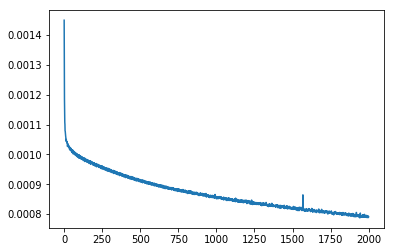

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()

### save model

In [19]:
model.save('model_save')